## Data preparation
1. Clip the land use map into tiles
2. Clip the NAIP images into tiles
3. Split the data into two major componments, training and testing

By Xiaojiang Li, Dec 6, 2024

In [2]:
!pip install path
#!pip install rasterio
#!pip install shapely

In [3]:
import os, os.path
from path import Path
import shutil
import rasterio as rio
import rasterio
from rasterio.windows import get_data_window
from rasterio.windows import Window
import rasterio.mask
import json
from shapely.geometry import Polygon
import random
import numpy as np
import argparse

### 1. Clip the land use/cover map

In [5]:
def raster2tiles(input_value_raster, tile_width_in, tile_height_in, outfolder): 
    '''This is function is used to clip the raster data into many smaller 
    fixed size of tiles
    
    Parameter: 
        input_value_raster: the filename of the input raster
        tile_width_in: the specified tile width
        tile_height_in: the specified tile height
        outfolder: the ouput dsm folder
    '''
    
    lu_dataset = rasterio.open(input_value_raster)
    lu_img = lu_dataset.read()
    
    # height and width of the raster
    height, width = lu_dataset.shape

    # split the large raser into number of tiles, tile size is 2000*2000
    tile_width = tile_width_in
    tile_height = tile_height_in

    tile_num_col = int(width/tile_width + 0.5)
    tile_num_row = int(height/tile_height + 0.5)

    # the output folder
    if not os.path.exists(outfolder): os.mkdir(outfolder)

    # create each tile
    for i in range(tile_num_row):
        # re-initiate the tile width when reach the right boundary
        tile_width = tile_width_in
        row_start = i*tile_height

        # loop each column
        for j in range(tile_num_col):
            # print('The i and j is:', i, j)
            tilename = os.path.join(outfolder, 'row%s-col%s.tif'%(i, j))
            
            col_start = j*tile_width
            row_end = (i + 1)*tile_height
            col_end = (j + 1)*tile_width
            
            # deal with the right boundary
            if row_end > height - 1: tile_height = height - row_start
            if col_end > width - 1: tile_width = width - col_start
            
            # window = get_data_window(lu_dataset.read(1, masked=True))
            window = Window(col_off=col_start, row_off=row_start, width=tile_width, height=tile_height)
            
            kwargs = lu_dataset.meta.copy()
            kwargs.update({
                'height': window.height,
                'width': window.width,
                'transform': rasterio.windows.transform(window, lu_dataset.transform)})
            
            img_window = lu_dataset.read(window=window)
            if img_window.min() <= 0: continue
            with rasterio.open(tilename, 'w', **kwargs) as dst:
                dst.write(img_window)


We will need to download the NAIP imagery ([link](https://utilitiesfiles.s3.us-east-1.amazonaws.com/penn-class/ai-urban-sustainability/data/naip-philly.tif)) and the land use map ([link](https://utilitiesfiles.s3.us-east-1.amazonaws.com/penn-class/ai-urban-sustainability/data/lu_phily.tif)) in Philadelphia. 

In [7]:
root = '../data'
root = '/Users/xiaojiang/Downloads'

# landcover_file = os.path.join(root, 'lu_phily.tif')
# naip_file = os.path.join(root, 'proj-philadelphia-naip.tif')
landcover_file = os.path.join(root, 'lu_phily.tif')
naip_file = os.path.join(root, 'naip-phily.tif')


# configure the training data folder
folder1 = os.path.join(root, 'dataset')
if not os.path.exists(folder1): os.mkdir(folder1)
foldertraining = os.path.join(folder1, 'trainning')
if not os.path.exists(foldertraining): os.mkdir(foldertraining)
train_label_folder = os.path.join(foldertraining, 'labels')
if not os.path.exists(train_label_folder): os.mkdir(train_label_folder)

tile_width = 256
tile_height = 256

raster2tiles(landcover_file, tile_width, tile_height, train_label_folder)


In [10]:
train_label_folder

'../data/dataset/trainning/labels'

Let open one tile and see

In [8]:
tilefile = os.path.join(train_label_folder, 'row14-col138.tif')
os.path.exists(tilefile)

True

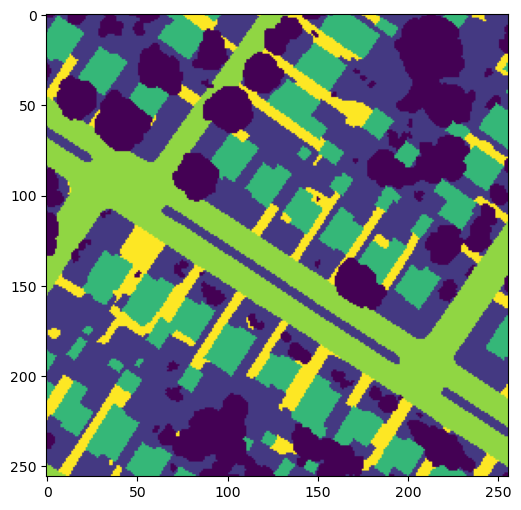

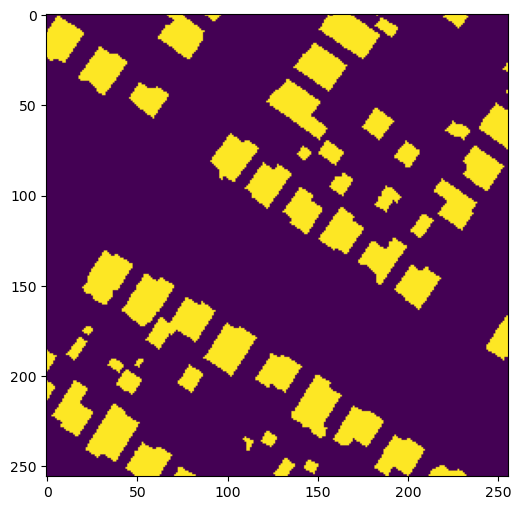

In [10]:
from matplotlib import pyplot as plt

tilefile = os.path.join(train_label_folder, 'row14-col138.tif')
lu_dataset = rasterio.open(tilefile)
lu_img = lu_dataset.read()
lu_img = lu_img.reshape(lu_img.shape[1], lu_img.shape[2])

plt.figure(figsize=(6, 6))
plt.imshow(lu_img)

plt.figure(figsize=(6, 6))
plt.imshow(lu_img == 5)

In [9]:
lu_img.shape

(256, 256)

### Cut the NAIP into tiles
Here we are going to use the boundary of those landuse tiles to cut the NAIP imagery into tiles.

In [14]:
def naip2tiles(naip_file, lu_folder, naip_tile_folder):
    '''
    Clip the NAIP tiles into tiles based on the size and geoinformation from the 
    clipped land use/cover tiles
    '''
    
    lu_dataset = rasterio.open(naip_file)
    lu_bounds = lu_dataset.bounds
    lu_box = Polygon([(lu_bounds.left, lu_bounds.bottom), \
                      (lu_bounds.left, lu_bounds.top), \
                      (lu_bounds.right, lu_bounds.top), \
                      (lu_bounds.right, lu_bounds.bottom)])
    
    for file in os.listdir(lu_folder):
        basename = os.path.basename(file)
        
        dem_data = rasterio.open(os.path.join(lu_folder, file))
        dem_bounds = dem_data.bounds
        left = dem_bounds.left
        bottom = dem_bounds.bottom
        right = dem_bounds.right
        top = dem_bounds.top    
        
        tile_box = Polygon([(left, bottom), \
                            (left, top), \
                            (right, top), \
                            (right, bottom)])
        
        # check if the dem tile is intersects with the big land use map
        overlap = lu_box.intersects(tile_box)
        if not overlap: continue
        
        # print('The left, botton, right, and top are:', left, bottom, right, top)
        shape = [{'type': 'Polygon', 'coordinates': [[[left, top], [right, top], \
                                                      [right, bottom], [left, bottom], [left, top]]]}]
        
        
        # mask the raster using the polygon, if crop is False, the size would be extremely large
        out_image, out_transform = rasterio.mask.mask(lu_dataset, shape, crop=True)
        
        # prepare the schema of the new tiles
        out_meta = lu_dataset.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform,
                         "crs": lu_dataset.crs}
                       )
        
        out_tif = os.path.join(naip_tile_folder, basename)
        with rasterio.open(out_tif, "w", **out_meta) as dest:
            dest.write(out_image)
        

In [15]:
train_img_folder = os.path.join(foldertraining, 'imgs')
if not os.path.exists(train_img_folder): os.mkdir(train_img_folder)

naip2tiles(naip_file, train_label_folder, train_img_folder)


The left, botton, right, and top are: 2717741.4998999997 261359.1693 2718253.4998999997 261871.1693
The left, botton, right, and top are: 2715693.4998999997 255727.1693 2716205.4998999997 256239.1693
The left, botton, right, and top are: 2714669.4998999997 261871.1693 2715181.4998999997 262383.1693
The left, botton, right, and top are: 2720301.4998999997 258799.1693 2720573.4998999997 259311.1693
The left, botton, right, and top are: 2720301.4998999997 255727.1693 2720573.4998999997 256239.1693
The left, botton, right, and top are: 2720301.4998999997 263919.1693 2720573.4998999997 264431.1693
The left, botton, right, and top are: 2718253.4998999997 259311.1693 2718765.4998999997 259823.1693
The left, botton, right, and top are: 2718253.4998999997 260335.1693 2718765.4998999997 260847.1693
The left, botton, right, and top are: 2715693.4998999997 262895.1693 2716205.4998999997 263407.1693
The left, botton, right, and top are: 2714157.4998999997 258287.1693 2714669.4998999997 258799.1693


The left, botton, right, and top are: 2719277.4998999997 260847.1693 2719789.4998999997 261359.1693
The left, botton, right, and top are: 2720301.4998999997 257263.1693 2720573.4998999997 257775.1693
The left, botton, right, and top are: 2719789.4998999997 258287.1693 2720301.4998999997 258799.1693
The left, botton, right, and top are: 2713133.4998999997 263407.1693 2713645.4998999997 263919.1693
The left, botton, right, and top are: 2716205.4998999997 257263.1693 2716717.4998999997 257775.1693
The left, botton, right, and top are: 2716205.4998999997 264431.1693 2716717.4998999997 264943.1693
The left, botton, right, and top are: 2710573.4998999997 263407.1693 2711085.4998999997 263919.1693
The left, botton, right, and top are: 2720301.4998999997 260847.1693 2720573.4998999997 261359.1693
The left, botton, right, and top are: 2719789.4998999997 262383.1693 2720301.4998999997 262895.1693
The left, botton, right, and top are: 2714157.4998999997 256239.1693 2714669.4998999997 256751.1693


We can check what the NAIP tile look like

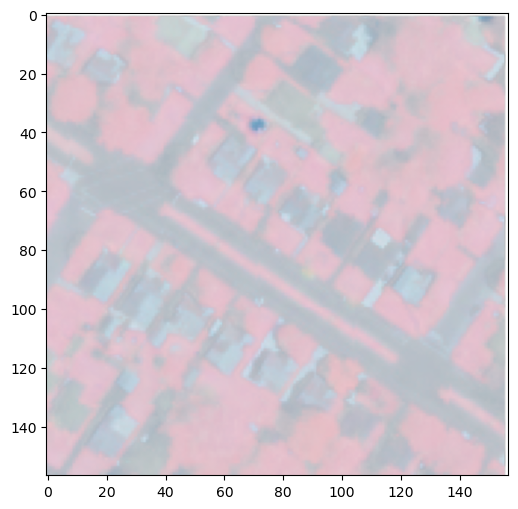

In [16]:
from matplotlib import pyplot as plt

tilefile = os.path.join(train_img_folder, 'row14-col138.tif')
naip_dataset = rasterio.open(tilefile)
naip_img = naip_dataset.read()
naip_img = naip_img.transpose(1, 2, 0)

plt.figure(figsize=(6, 6))
plt.imshow(naip_img)

In [19]:
train_img_folder

'../data/dataset/trainning/imgs'

In [17]:
naip_img.shape, lu_img.shape


((157, 157, 4), (256, 256))

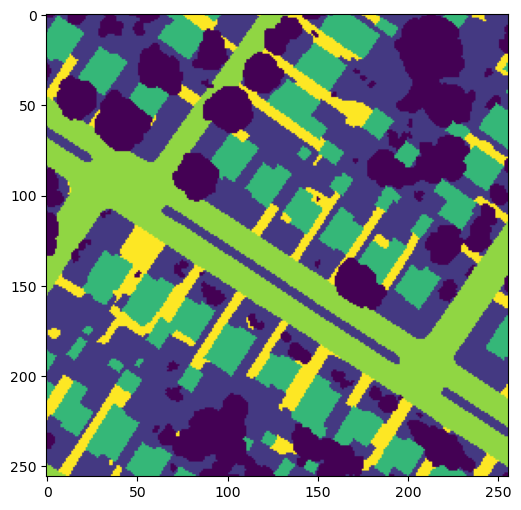

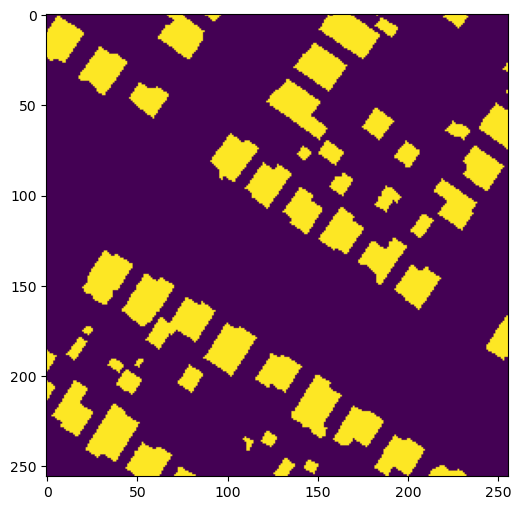

In [18]:
from matplotlib import pyplot as plt

tilefile = os.path.join(train_label_folder, 'row14-col138.tif')
lu_dataset = rasterio.open(tilefile)
lu_img = lu_dataset.read()
lu_img = lu_img.reshape(lu_img.shape[1], lu_img.shape[2])

plt.figure(figsize=(6, 6))
plt.imshow(lu_img)

plt.figure(figsize=(6, 6))
plt.imshow(lu_img == 5)

In [26]:
# naip_img

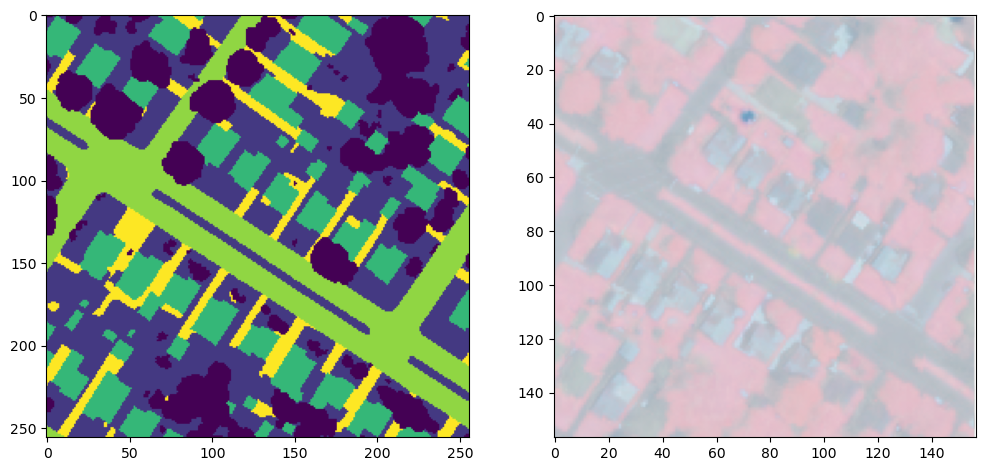

In [19]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2, figsize=(12,12)) 

axarr[0].imshow(lu_img)
axarr[1].imshow(naip_img)

### 3. Split the dataset into training and testing
For the trainning purpose, we need to split the dataset into two sections, for training and testing. 


In [20]:

def split_train_validate(training_img_dir, training_labels_dir, validation_img_dir, validation_labels_dir, split = 5):
    '''split the training dataset into training and validationg parts, randomly
    select 20% of the training datast (imgs and labels) into the validation folder
    '''
    ## split the train dataset and validation dataset
    img_sample = random.sample(Path(training_img_dir).files(), len(Path(training_img_dir).files())//split )

    if not os.path.exists(validation_img_dir): os.mkdir(validation_img_dir)
    if not os.path.exists(validation_labels_dir): os.mkdir(validation_labels_dir)

    for i in img_sample:
        from_img_name = os.path.join(training_img_dir, i.name)
        shutil.move(os.path.join(training_img_dir, i.name), os.path.join(validation_img_dir, i.name))
        shutil.move(os.path.join(training_labels_dir, i.name), os.path.join(validation_labels_dir, i.name))
    

In [21]:
# the validataon folder
valid_folder = os.path.join(folder1, 'validation')
if not os.path.exists(valid_folder): os.mkdir(valid_folder)
valid_label_folder = os.path.join(valid_folder, 'labels')
if not os.path.exists(valid_label_folder): os.mkdir(valid_label_folder)
valid_img_folder = os.path.join(valid_folder, 'imgs')
if not os.path.exists(valid_img_folder): os.mkdir(valid_img_folder)

split_train_validate(train_img_folder, train_label_folder, valid_img_folder, valid_label_folder)


In [23]:
folder1

'/Users/xiaojiang/Downloads/dataset'